# Measure intensity vs. time in angular or concentric regions

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.io

import matplotlib
cmap = matplotlib.colors.ListedColormap(np.random.rand(256,3))

from microfilm.dataset import MultipageTIFF
import microfilm.microplot
from splitmask import splitmask

## Define paths to image and roi

In [17]:
image_path = '../splitmask/tests/test_folders/test_multipage_good/'
roi_path = '../splitmask//tests/test_folders/test_multipage_good/roi.bmp'

## Import data

Here we use a ```MultipageTIFF``` dataset as defined in the ```from microfilm.dataset``` module. We can however exchange this for a tif series, h5 or Nikon ND2 file.

In [18]:
image = MultipageTIFF(image_path)
roi = skimage.io.imread(roi_path)

## create roi
#import skimage.morphology
#roi = np.zeros(image.dims, dtype=np.uint8)
#roi[70,90] = 1
#roi = 255*skimage.morphology.binary_dilation(roi, skimage.morphology.disk(10)).astype(np.uint8)
#skimage.io.imsave('../tests/test_folders/test_multipage_good/roi.bmp', roi)

In [19]:
image.channel_name

['C1-MAX_mitosis.tif', 'C2-MAX_mitosis.tif']

## Measure the roi center of mass

In [20]:
cm = splitmask.get_roi_cm(roi_im=roi)

In [21]:
im_np = image.load_frame(channel_name=image.channel_name[1], frame=20)

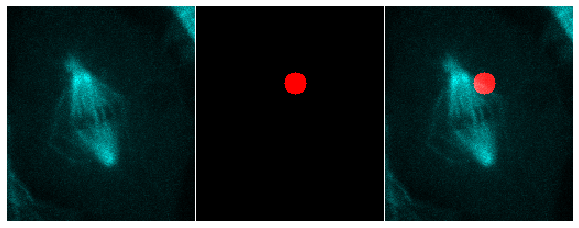

In [22]:
panel = microfilm.microplot.Micropanel(1,3, figscaling=3)
panel.add_element(pos = [0,0], microim=microfilm.microplot.Microimage(im_np, cmaps=['pure_cyan']))
panel.add_element(pos = [0,1], microim=microfilm.microplot.Microimage(roi))
panel.add_element(pos = [0,2], microim=microfilm.microplot.Microimage([im_np, roi],['pure_cyan', 'pure_red']))

## Radial sectors

Here we create a labelled image with sectors as concentric rings. We can define the width and the number of rings.

We also create a colormap which optimally scales for the number of regions generated. The color map can be used both to display the labelled image and for regular plots (see below).

In [23]:
sector_width = 5
num_sectors = 10

In [24]:
radius_labels = splitmask.create_concentric_mask(center=cm, im_dims=image.dims,
                                                         sector_width=sector_width, num_sectors=num_sectors)
colors_rad, cmap_rad = splitmask.get_cmap_labels(radius_labels, cmap_name='cool')

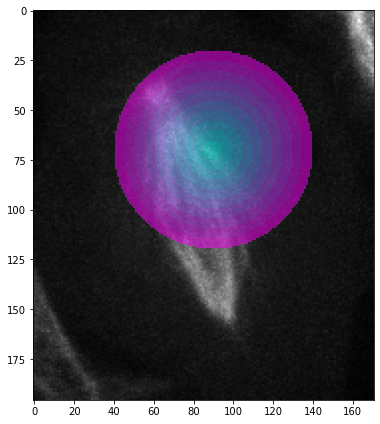

In [25]:
myplot = splitmask.plot_sectors(image, radius_labels, cmap=cmap_rad, channel=image.channel_name[1]);

To save the figure, just use:

In [26]:
myplot.savefig('mysectors.png')

### Changing the image colormap

You can also use the microfilm package to generate and use alternative colormaps for the image plot itself. For example if you want to have a gray-scale inverted colormap:

In [27]:
gray_invert = microfilm.colorify.cmaps_def('gray', flip_map=True)

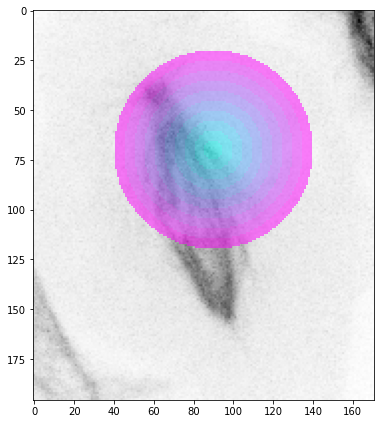

In [28]:
myplot = splitmask.plot_sectors(image, radius_labels, cmap=cmap_rad, im_cmap=gray_invert, channel=image.channel_name[1]);

## Angular sectors

Here we create a labelled image with sectors as "pie" parts of a disk. We can define the angular size of the parts and the radius of the disk. Again, we create an optimal color map.

In [29]:
angular_width = 20
max_rad =50
sector_labels = splitmask.create_sector_mask(center=cm, im_dims=image.dims,
                                                     angular_width=angular_width, max_rad=max_rad)
colors_angle, cmap_angle = splitmask.get_cmap_labels(sector_labels, cmap_name='viridis')

To display the image and the sectors, you can use the ```plot_sectors``` function:

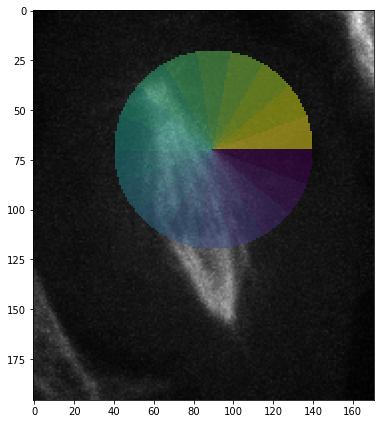

In [30]:
splitmask.plot_sectors(image, sector_labels, cmap=cmap_angle, channel=image.channel_name[1]);

## Angular and radial sectors

We can also combine the radial and angular masks, to create only a ring with a given width. For that we use again the ```create_sector_mask``` function but use **and additional parameter ```radius``` for the ring width**.

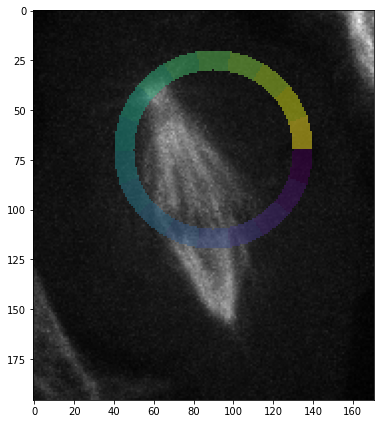

In [31]:
angular_width = 20
max_rad = 50
ring_width = 10
sector_labels = splitmask.create_sector_mask(center=cm, im_dims=image.dims,
                                                     angular_width=angular_width, max_rad=max_rad, ring_width=ring_width)
colors_angle, cmap_angle = splitmask.get_cmap_labels(sector_labels, cmap_name='viridis')

splitmask.plot_sectors(image, sector_labels, cmap=cmap_angle, channel=image.channel_name[1]);

## Extracting signals

With the labelled image of sectors and the time-lapse data, we can now extract the intensity in each sector across time and plot it. If multiple channels are available in the dataset, we can change it.

In [32]:
channel = image.channel_name[1]

signal_radius = splitmask.measure_intensities(time_image=image.frame_generator(channel=channel), 
                                                      im_labels=radius_labels,max_time=300)
signal_angle = splitmask.measure_intensities(time_image=image.frame_generator(channel=channel), 
                                                     im_labels=sector_labels,max_time=300)


To plot the signals you can use the ```plot_signals``` function. You can pass the colormap array produced by the ```get_cmap_labels``` function to color the curves with the same colors as the corresponding sectors.


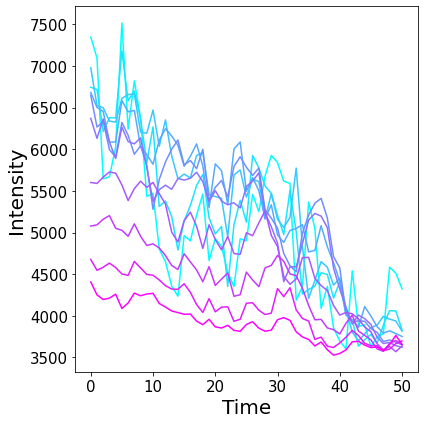

In [33]:
myplot = splitmask.plot_signals(signal_radius, color_array=colors_rad);

### Extracting signal from multiple channels

Instead of a single channel, you can also provide a list of channels from where to extract the signal:

In [34]:
channels = image.channel_name
channels

['C1-MAX_mitosis.tif', 'C2-MAX_mitosis.tif']

In [35]:
signal_radius_multi = splitmask.measure_intensities(
    time_image=image.frame_generator(channel=channels), 
    im_labels=radius_labels)

In [36]:
signal_radius_multi.shape

(51, 10, 2)

Now the output has an additional dimension corresponding to the number of channels, here 2. You can now plot them separately:

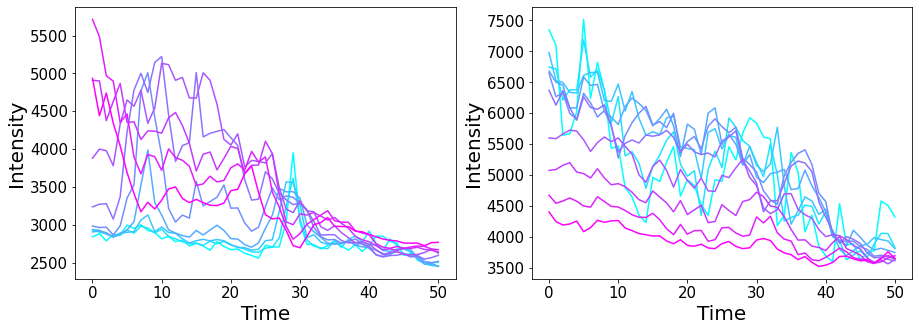

In [37]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
splitmask.plot_signals(signal_radius_multi[:,:,0], color_array=colors_rad, ax=ax[0])
splitmask.plot_signals(signal_radius_multi[:,:,1], color_array=colors_rad, ax=ax[1]);
                                  

### Limited time points

You can also limit your analyis to a given fraction of the time lapse using the ```max_time```, ```min_time``` and ```steps``` parameters:

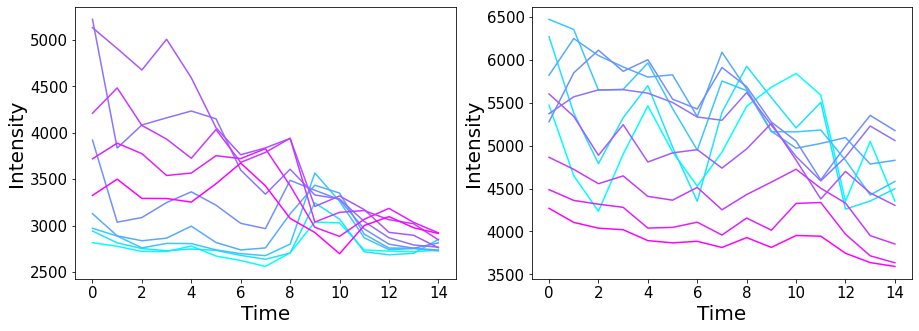

In [38]:
signal_radius_multi = splitmask.measure_intensities(
    time_image=image.frame_generator(channel=channels), 
    im_labels=radius_labels, min_time=10, max_time=40, step=2)

fig, ax = plt.subplots(1,2, figsize=(15,5))
splitmask.plot_signals(signal_radius_multi[:,:,0], color_array=colors_rad, ax=ax[0])
splitmask.plot_signals(signal_radius_multi[:,:,1], color_array=colors_rad, ax=ax[1]);    

Note that the time axis is not correct here and needs to be manually adjusted.

## Plotting

The plotting functions return simple Matplotlib axes, so one can combine them into more complex plots:

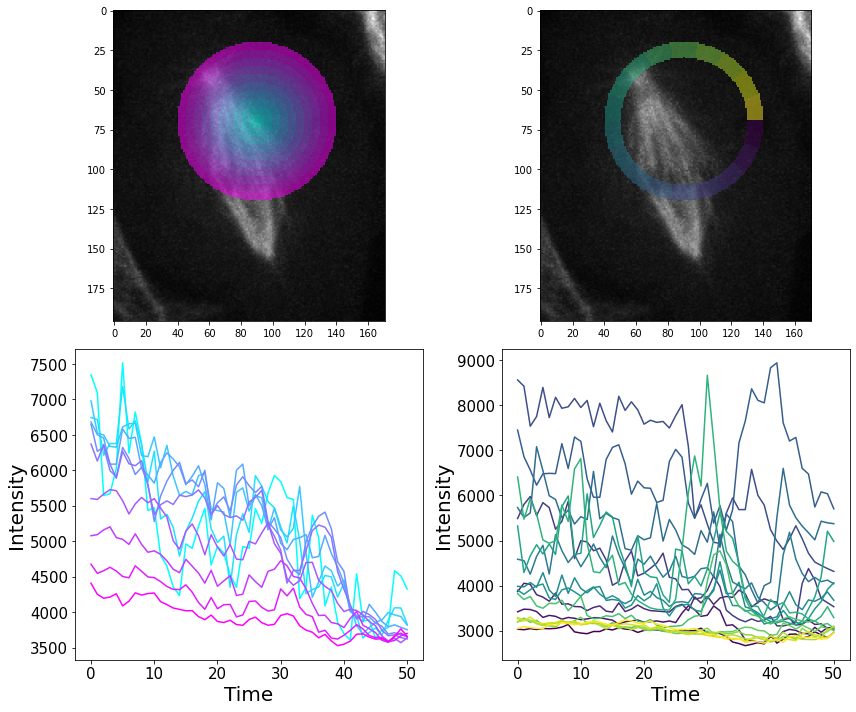

In [40]:
fig, ax = plt.subplots(2,2, figsize=(12,10))

splitmask.plot_signals(signal_radius, color_array=colors_rad, ax=ax[1,0]);
splitmask.plot_signals(signal_angle, color_array=colors_angle, ax=ax[1,1]);

splitmask.plot_sectors(image, radius_labels, cmap=cmap_rad, ax=ax[0,0], channel=image.channel_name[1]);
splitmask.plot_sectors(image, sector_labels, cmap=cmap_angle, ax=ax[0,1], channel=image.channel_name[1]);
plt.tight_layout()

## Export

To save a simple plot you can use the Matplotlib ```savefig``` function with all its options. This works both for the image plots and the signal plots:

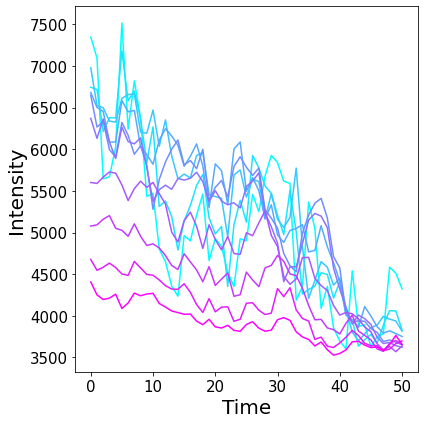

In [41]:
myplot = splitmask.plot_signals(signal_radius, color_array=colors_rad);

myplot.savefig('myplot.png')

To export the data as CSV file use the ```save_signal``` function. You can export in two different format, 'long' or 'wide'. In long format you obtain a table with three columns - time, sector, intensity - while in 'wide' format the rows correspond to time and the columns to sectors.

In [42]:
splitmask.save_signal(signal=signal_radius, name='signal_radius_long.csv', format='long')

splitmask.save_signal(signal=signal_radius, name='signal_radius_wide.csv', format='wide')

When saving data for multiple channels, an additional column is added in long format containing the channel name which has to be provided via the ```channels``` parameter:

In [43]:
splitmask.save_signal(signal=signal_radius_multi,
                                 name='signal_radius_long_multi.csv', format='long', channels=channels)


To re-import the data you can just use the standard Pandas reader:

In [44]:
import pandas as pd
pd.read_csv('signal_radius_long_multi.csv')

,time,sector,intensity,channel
0,0,0,2815.985507,C1-MAX_mitosis.tif
1,1,0,2778.159420,C1-MAX_mitosis.tif
2,2,0,2722.028986,C1-MAX_mitosis.tif
3,3,0,2721.028986,C1-MAX_mitosis.tif
4,4,0,2781.217391,C1-MAX_mitosis.tif
...,...,...,...,...
295,10,9,3953.059621,C2-MAX_mitosis.tif
296,11,9,3945.169377,C2-MAX_mitosis.tif
297,12,9,3746.560298,C2-MAX_mitosis.tif
298,13,9,3637.620596,C2-MAX_mitosis.tif


## Interactive display

In [30]:
import ipywidgets as ipw

In [9]:
%matplotlib widget

In [33]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0] = splitmask.plot_sectors(image, sector_labels, cmap=cmap_angle, ax=ax[0])
ax[1] = splitmask.plot_signals(signal_angle, color_array=colors_angle, ax=ax[1])  
time_line = ax[1].plot([0,0],[signal_angle.min(), signal_angle.max()],'-r')
plt.tight_layout()

def plot_sectors_time(t):
    ax[0].get_images()[0].set_data(image.load_frame(image.channel_name[0],t)) 
    time_line[0].set_xdata([t,t])
    
ipw.interactive(plot_sectors_time, t=ipw.IntSlider(value=0, min=0, max=image.max_time-1))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(IntSlider(value=0, description='t', max=50), Output()), _dom_classes=('widget-interact',…